# Hyperparamètres - Variation du nombre d'époques

## Objectif
La démarche de recherche avec variation du nombre d'époques doit nous permettre de déterminer leur nombre optimal. Suite aux premiers tests, nous allons réduire la plage de recherche à 7, 10 et 13 époques.

## Hypothèses
Les hypothèses sont les suivantes :

- Le nombre d'époques optimal est celui qui permet d'obtenir le meilleur score de validation.
- Un nombre d'époques trop faible ne permet pas au modèle d'apprendre suffisamment.
- Un nombre d'époques trop élevé peut conduire à un surapprentissage.

## Étapes de la démarche

- Intégrer l'objet GridSearchCV de Scikit-Learn.
- Définir les nombres d'époques à tester. (7, 10, 13)
- Récupérer les métriques de validation pour chaque nombre d'époques.
- Comparer les métriques de validation pour chaque nombre d'époques.
- Déterminer le nombre d'époques optimal.

## Conclusion

En conclusion, dans le cadre de nos recherches, avec nos données et notre modèle, le nombre d'époques optimal parmi ceux essayés est 13.

**Par rapport à la complexité de l'entrainement, les différents nombres d'époques seront comparés en utilisant des images de dimension 64x64**

In [60]:
import os
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Check that GPU is used
import tensorflow as tf
from keras import backend as K

tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

tf.compat.v1.reset_default_graph()
K.clear_session()
tf.config.list_physical_devices('GPU')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10793600308262509853
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10093477333135770389
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [61]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 64, 64 # Function to load and resize images from a folder

In [62]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [63]:
# Generate augmented for the training set
from data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 2954 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 2954
Augmented PNEUMONIA count: 5000


In [64]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

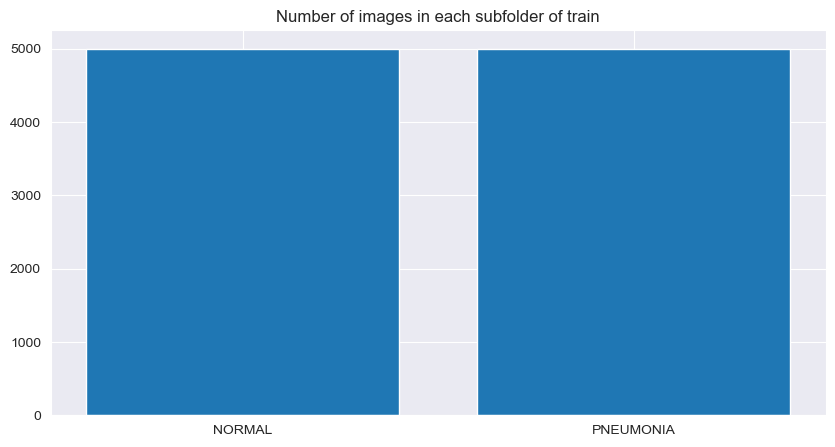

In [65]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

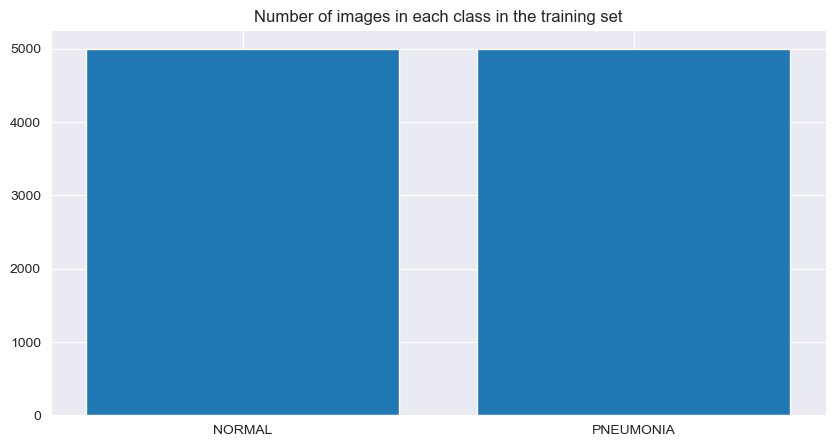

In [66]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [67]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(64, 64, 1)


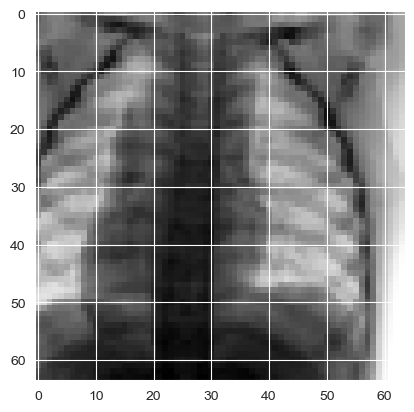

In [68]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [69]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [70]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [71]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [72]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the number of folds for cross-validation
n_splits = 5

# Wrap your create_model function with KerasClassifier
wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the range of epochs
epochs = [7, 10, 13]

param_grid = {
    'epochs': epochs,
}

datagen = ImageDataGenerator()

# Initialize the GridSearchCV object with your wrapped_model, param_grid, and the desired number of folds
grid_search = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, cv=n_splits, return_train_score=True)

# Combine X_train and X_val to use the whole dataset for GridSearchCV
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Fit the GridSearchCV object to your training data
grid_result = grid_search.fit(X_combined, y_combined, callbacks=[early_stop])

# Get the best number of epochs and the corresponding score
best_epochs = grid_result.best_params_['epochs']
best_score = grid_result.best_score_
# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))


C:\Users\proma\AppData\Local\Temp\ipykernel_8732\3011937871.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/7
251/251 [==============================] - 3s 8ms/step - loss: 0.5413 - accuracy: 0.7163 - auc: 0.7713
Epoch 2/7
251/251 [==============================] - 2s 7ms/step - loss: 0.3118 - accuracy: 0.8699 - auc: 0.9366
Epoch 3/7
251/251 [==============================] - 2s 7ms/step - loss: 0.2362 - accuracy: 0.9053 - auc: 0.9631
Epoch 4/7
251/251 [==============================] - 2s 7ms/step - loss: 0.1913 - accuracy: 0.9266 - auc: 0.9756
Epoch 5/7
251/251 [==============================] - 2s 7ms/step - loss: 0.1853 - accuracy: 0.9295 - auc: 0.9768
Epoch 6/7
251/251 [==============================] - 2s 7ms/step - loss: 0.1642 - accuracy: 0.9372 - auc: 0.9821
Epoch 7/7
251/251 [==============================] - 1s 3ms/step - loss: 0.1102 - accuracy: 0.9563 - auc: 0.9921
Epoch 1/7
251/251 [==============================] - 2s 7ms/step - loss: 0.5340 - accuracy: 0.7232 - auc: 0.9253
Epoch 2/7
251/251 [==============================] - 2s 7ms/step - loss: 0.3170 - accuracy: 0.87

In [73]:
# Get accuracy scores for each fold (train and validation)
# Initialize lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []

# Get the number of combinations tried during the grid search
n_combinations = len(grid_result.cv_results_['params'])

# Iterate over each combination tried during the grid search
for i in range(n_combinations):
    # Initialize empty lists for loss, accuracy, val_loss, and val_accuracy for this combination
    loss = []
    acc = []
    val_loss = []  # Note: GridSearchCV does not return loss or val_loss
    val_acc = []

    # Iterate through each fold and get the scores for this combination
    for fold in range(n_splits):
        acc.append(grid_result.cv_results_[f'split{fold}_train_score'][i])
        val_acc.append(grid_result.cv_results_[f'split{fold}_test_score'][i])

    # Calculate the mean scores for this combination
    loss_mean = np.nan  # GridSearchCV does not return loss
    acc_mean = np.mean(acc)
    val_loss_mean = np.nan  # GridSearchCV does not return val_loss
    val_acc_mean = np.mean(val_acc)

    # Append the mean scores to the histories list
    history = {
        "loss": loss_mean,
        "accuracy": acc_mean,
        "val_loss": val_loss_mean,
        "val_accuracy": val_acc_mean,
    }
    histories.append(history)

# Calculate mean accuracy scores across all folds for each combination
loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return loss
acc = [np.mean(history["accuracy"]) for history in histories]
val_loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return val_loss
val_acc = [np.mean(history["val_accuracy"]) for history in histories]

print("Loss for each combination: ", loss)
print("Accuracy for each combination: ", acc)
print("Validation loss for each combination: ", val_loss)
print("Validation accuracy for each combination: ", val_acc)

Loss for each combination:  [nan, nan, nan]
Accuracy for each combination:  [0.9648060917854309, 0.9712710022926331, 0.977161192893982]
Validation loss for each combination:  [nan, nan, nan]
Validation accuracy for each combination:  [0.9237203955650329, 0.9082426190376282, 0.9306090831756592]


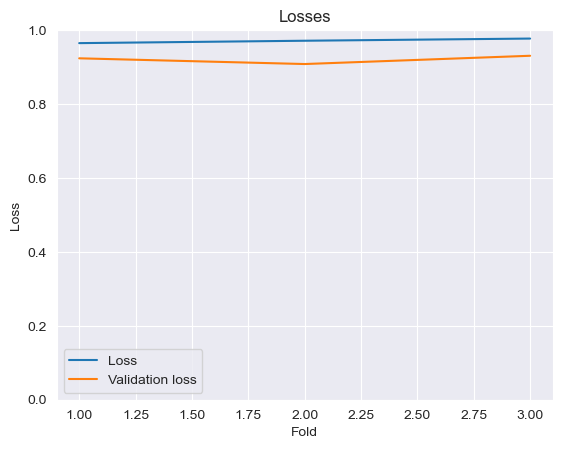

In [74]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

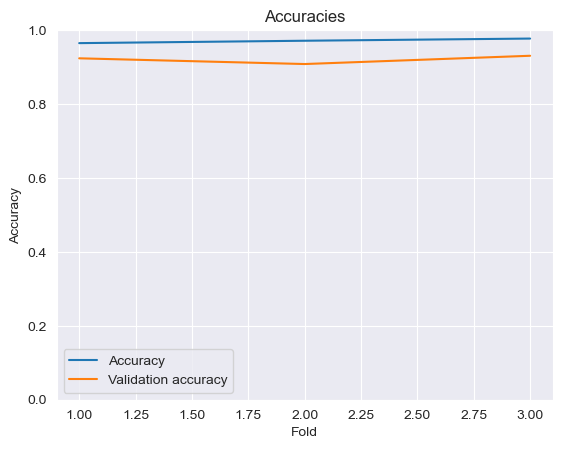

In [75]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=100)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=100)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs[0], verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
100/100 [==============================] - 3s 18ms/step - loss: 0.5988 - accuracy: 0.6493 - auc: 0.9253 - val_loss: 0.5606 - val_accuracy: 0.6875 - val_auc: 0.8594
Epoch 2/7
100/100 [==============================] - 2s 16ms/step - loss: 0.3125 - accuracy: 0.8790 - auc: 0.9366 - val_loss: 0.5299 - val_accuracy: 0.8125 - val_auc: 0.9062
Epoch 3/7
100/100 [==============================] - 2s 16ms/step - loss: 0.2547 - accuracy: 0.9056 - auc: 0.9584 - val_loss: 0.6642 - val_accuracy: 0.7500 - val_auc: 0.9453
Epoch 4/7
100/100 [==============================] - 2s 16ms/step - loss: 0.2049 - accuracy: 0.9220 - auc: 0.9730 - val_loss: 0.5279 - val_accuracy: 0.7500 - val_auc: 0.9688
Epoch 5/7
100/100 [==============================] - 2s 16ms/step - loss: 0.1748 - accuracy: 0.9359 - auc: 0.9798 - val_loss: 0.2943 - val_accuracy: 0.8750 - val_auc: 0.9844
Epoch 6/7
100/100 [==============================] - 2s 16ms/step - loss: 0.1575 - accuracy: 0.9421 - auc: 0.9838 - val_loss: 0.27

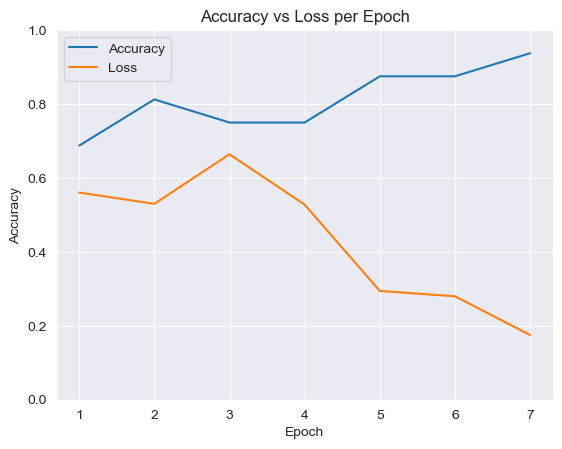

In [77]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 2ms/step


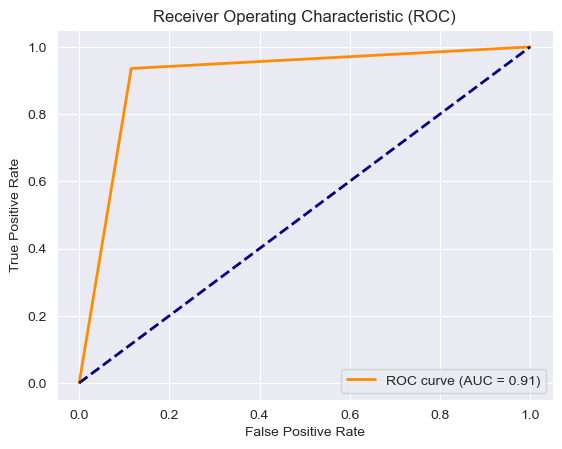

In [79]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [80]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[207  27]
 [ 25 365]]


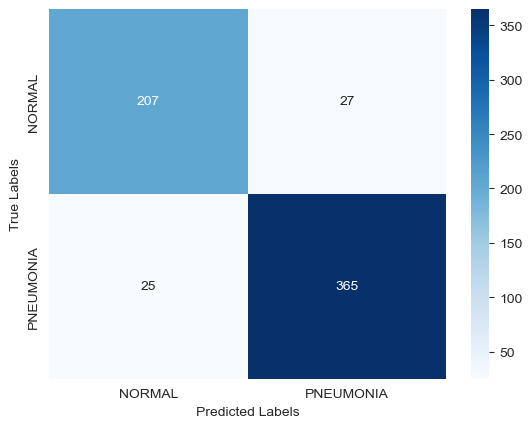

In [81]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [82]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.89      0.88      0.89       234
   PNEUMONIA       0.93      0.94      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



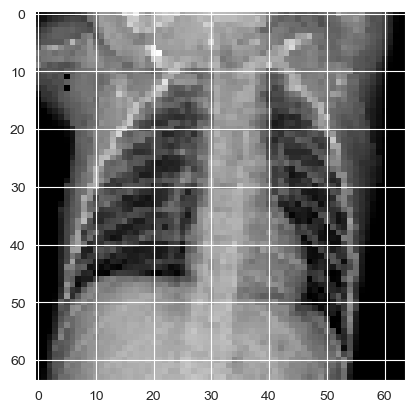

C:\Users\proma\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


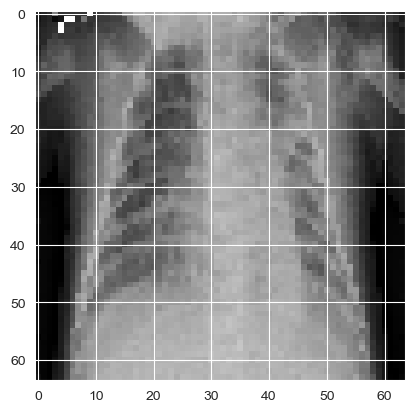

In [83]:
# Heatmaps and Grad-CAM
from cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [84]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [85]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 6, 6, 128)      

In [86]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_67"

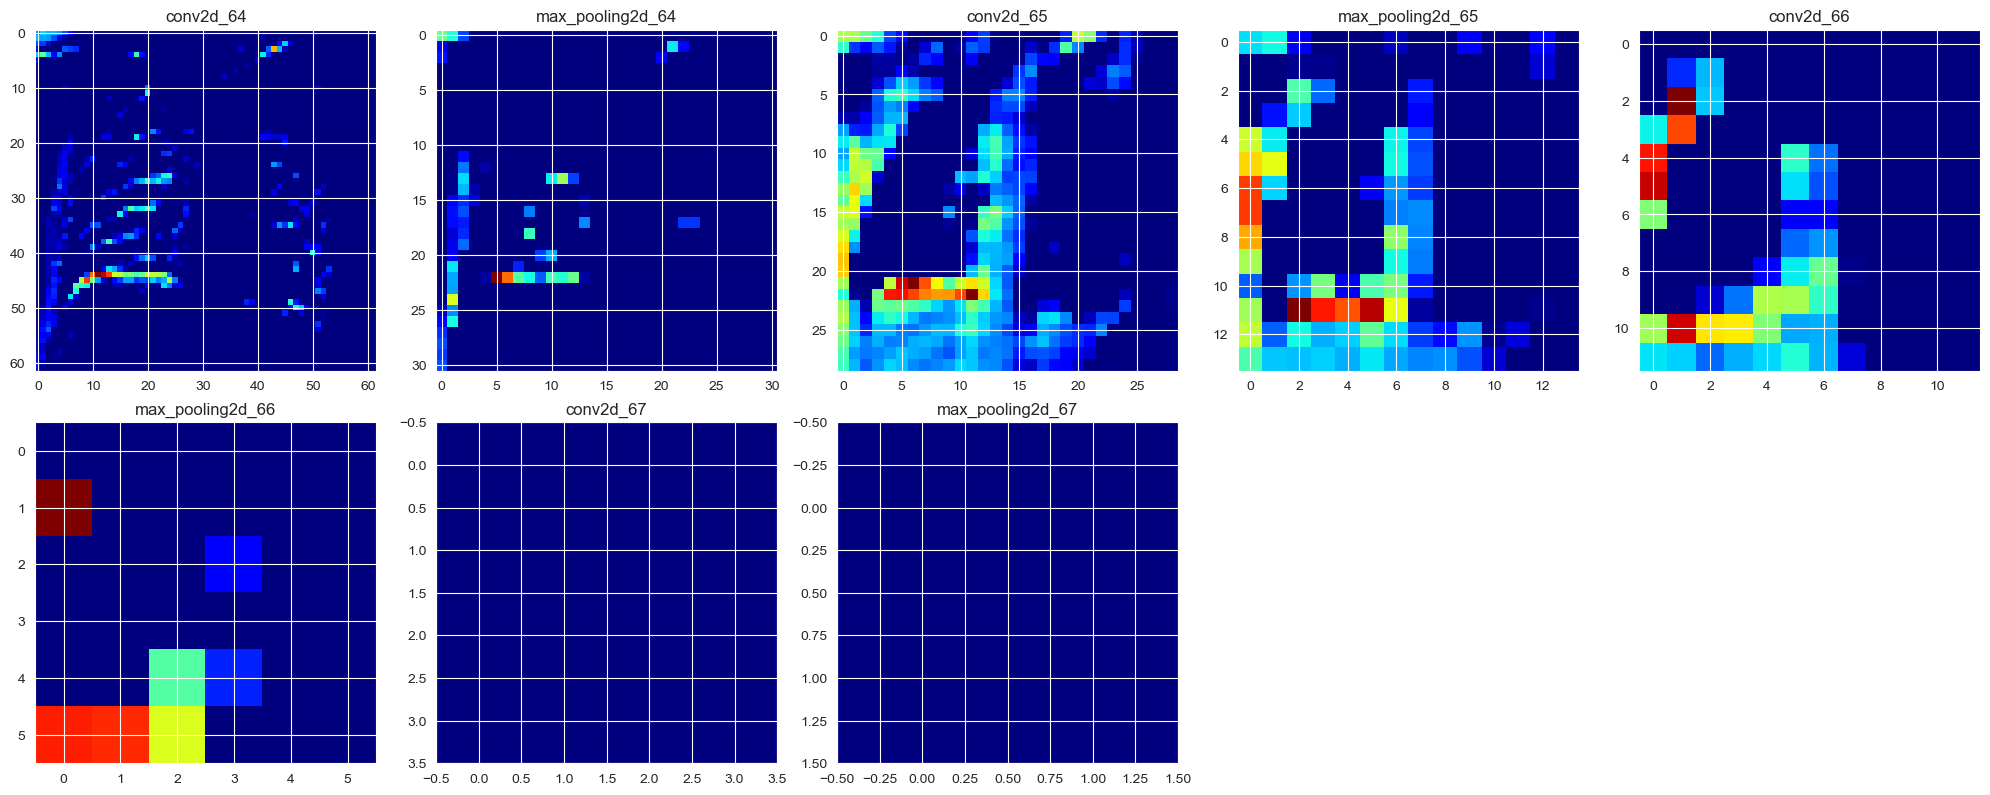

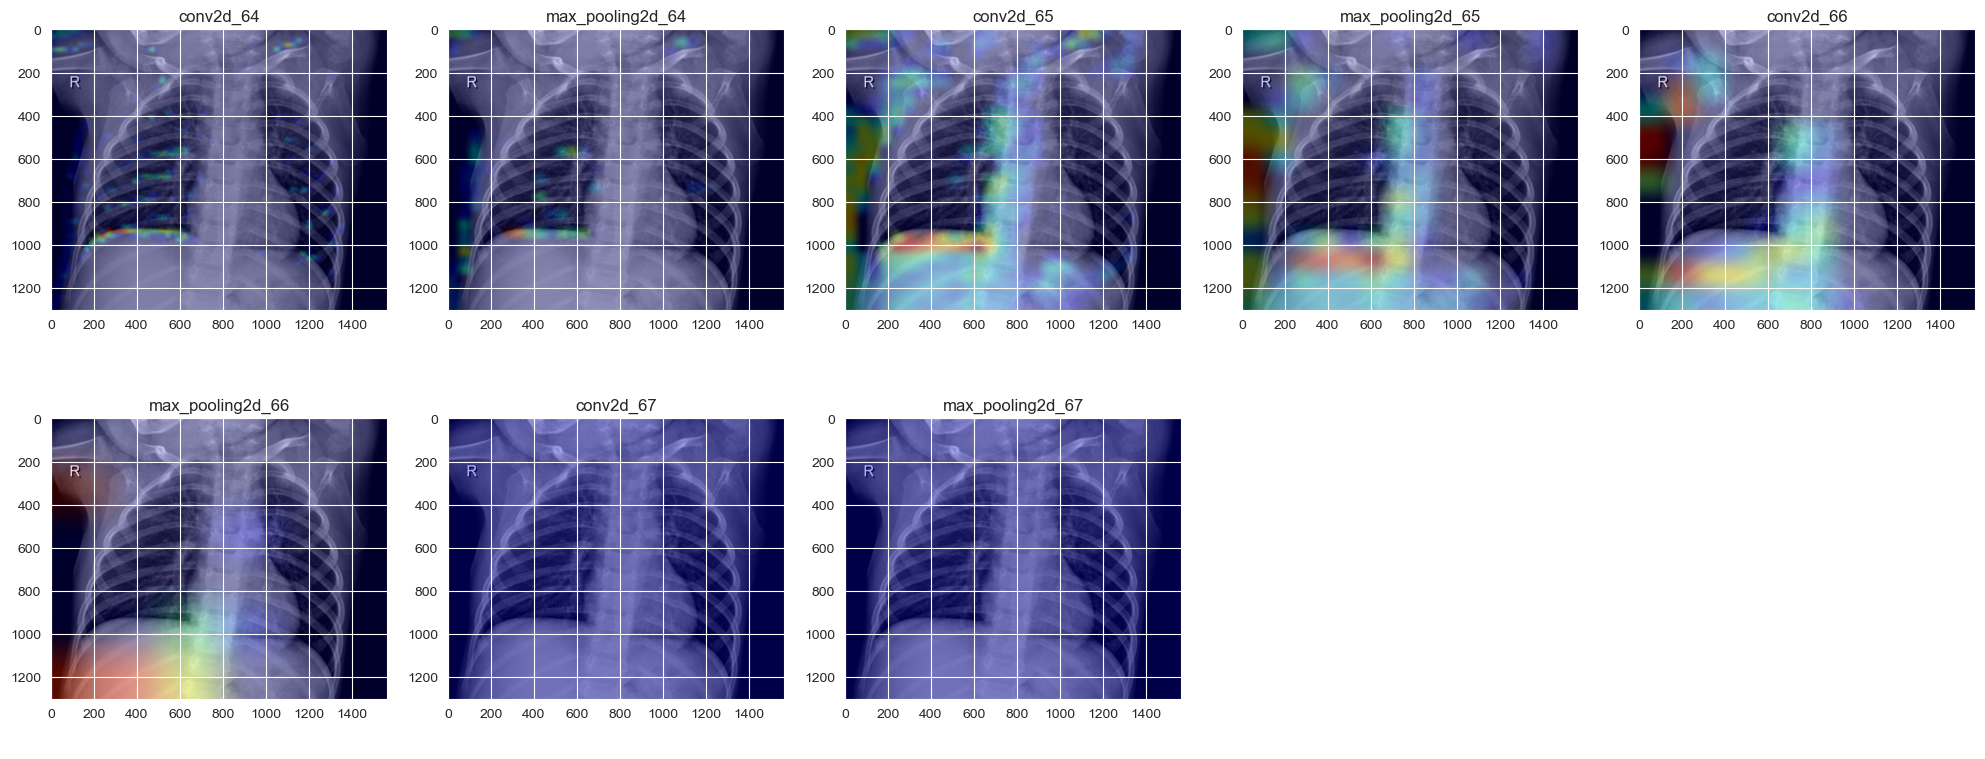

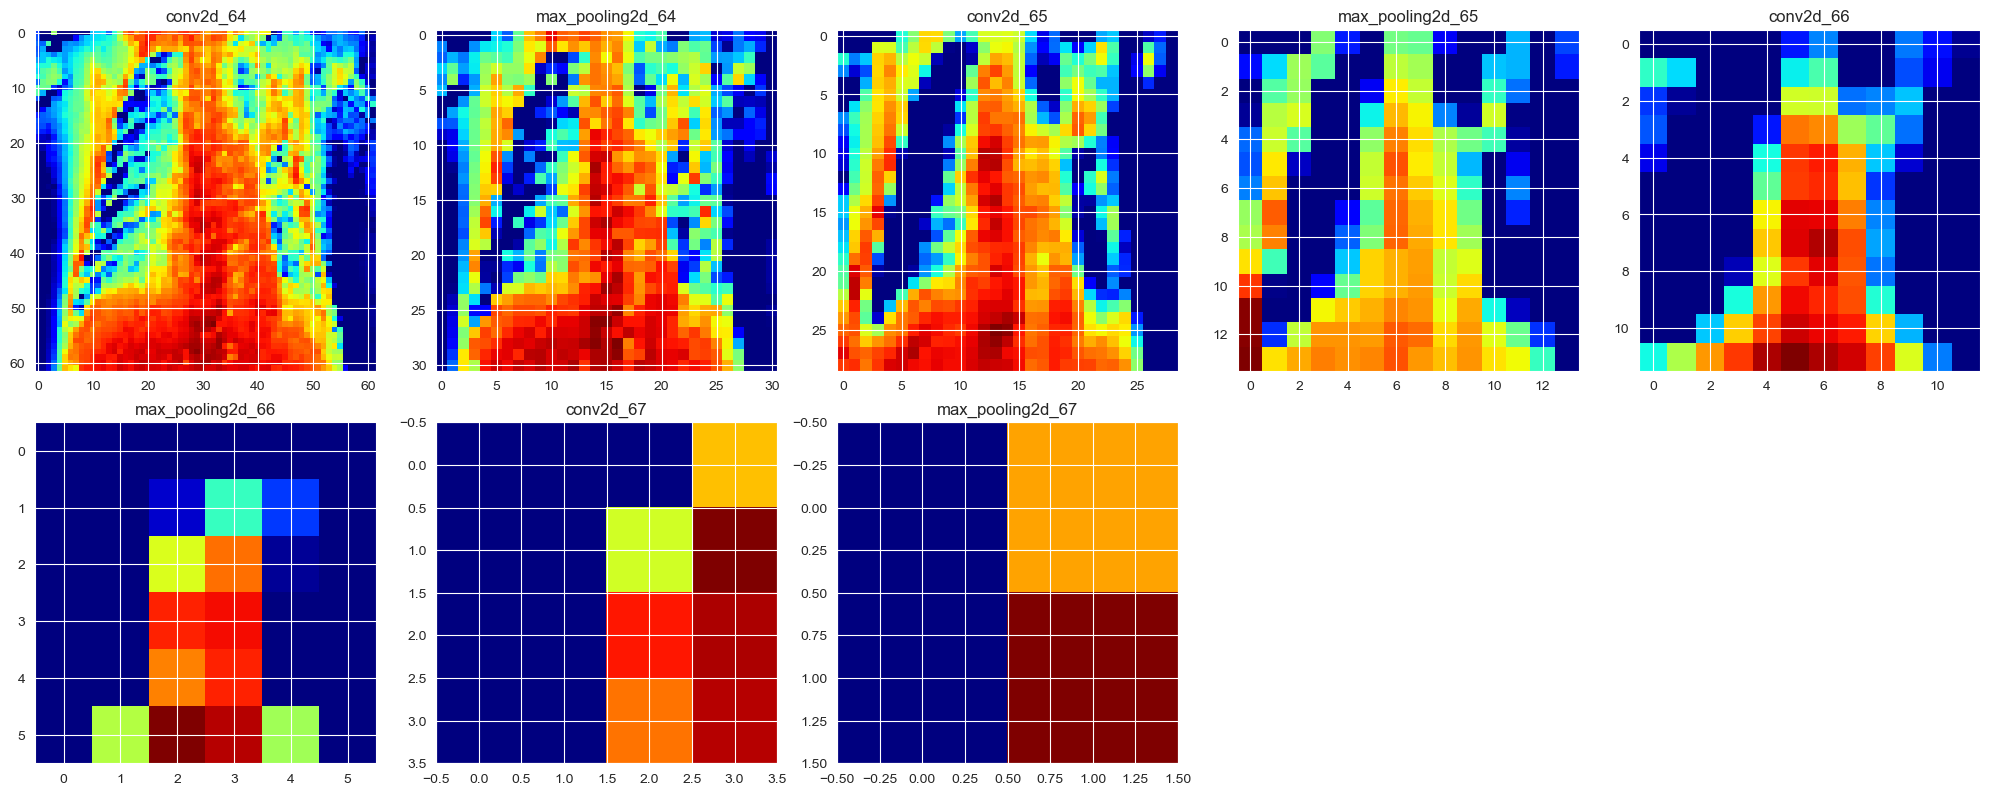

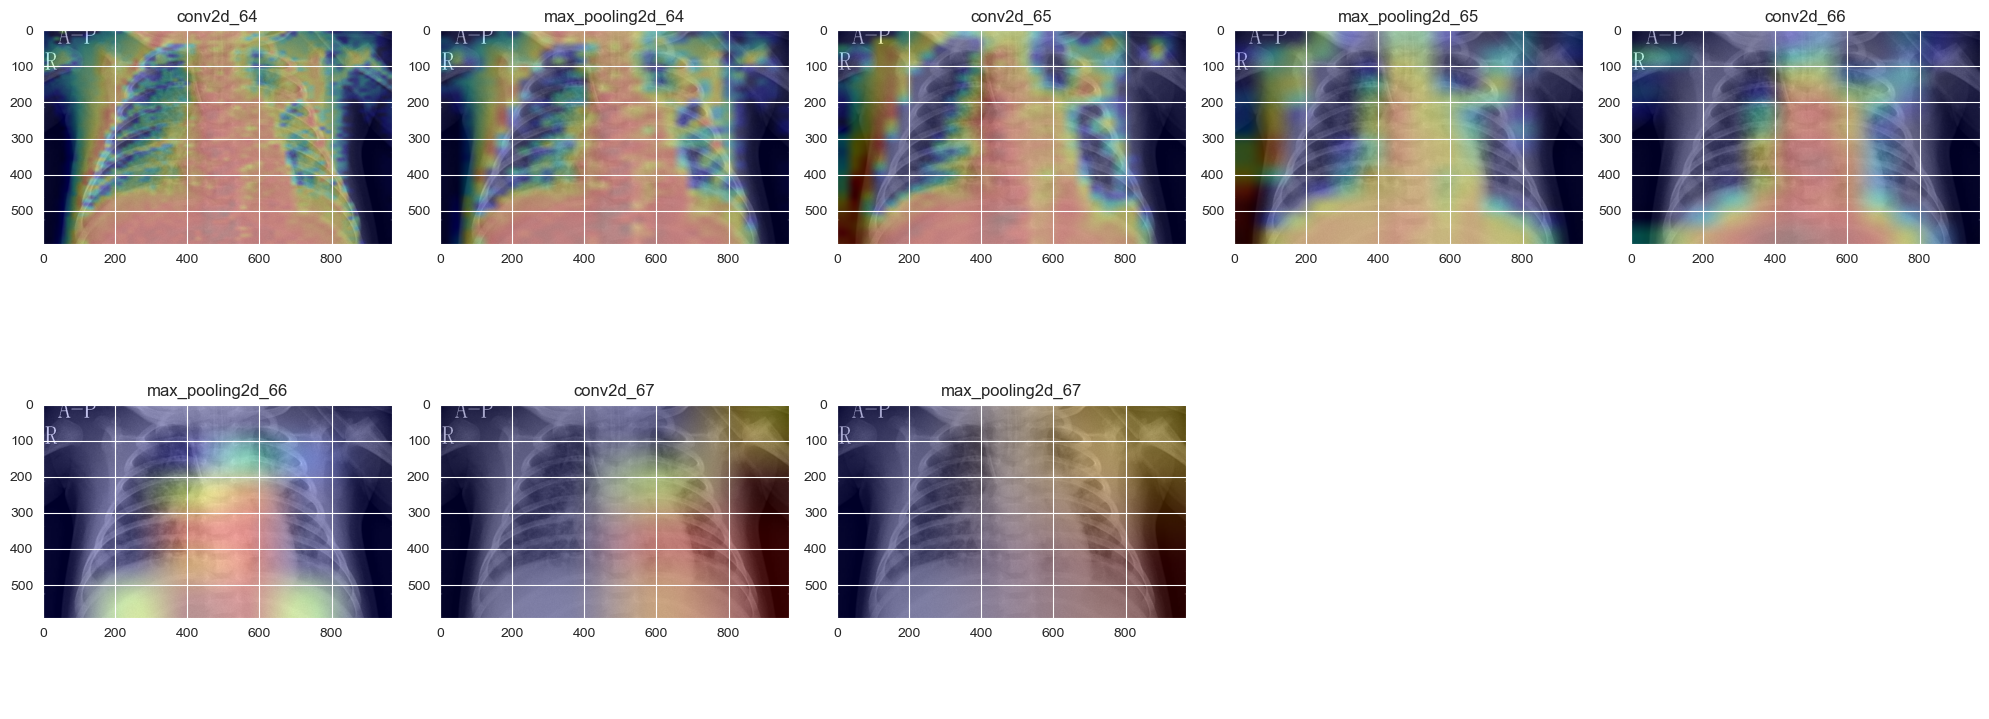

In [87]:
from cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [88]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 20ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 22ms/step
[[1.]]
Predicted class: PNEUMONIA
